# Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

In [3]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Reading the Data

In [6]:
df = pd.read_csv("Datasets/df_listings_stripped.csv")

# First Look at the Data

In [5]:
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [6]:
def general_info (dataframe):
    print('\033[1m' +f'{get_df_name(dataframe).upper()}'+'\033[0m')
    print("\n")
    print('\033[1m' +f" SHAPE ".center(30, '-')+'\033[0m')
    print(dataframe.shape,"\n")
    print('\033[1m' +f" VARIABLE TYPES ".center(30, '-')+'\033[0m')
    print(dataframe.info(),"\n")
    print('\033[1m' +f" NULL VALUE ".center(30, '-')+'\033[0m')
    print(dataframe.isnull().sum(),"\n")

In [7]:
general_info(df)

DF


----------- SHAPE ------------
(245139, 51) 

------- VARIABLE TYPES -------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245139 entries, 0 to 245138
Data columns (total 51 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   host_response_time                            177111 non-null  object 
 1   host_response_rate                            177111 non-null  object 
 2   host_acceptance_rate                          189118 non-null  object 
 3   host_is_superhost                             245035 non-null  object 
 4   host_listings_count                           245099 non-null  float64
 5   host_total_listings_count                     245099 non-null  float64
 6   host_verifications                            245139 non-null  object 
 7   host_has_profile_pic                          245099 non-null  object 
 8   host_identity_verified                    

# Exploratory Data Analysis (EDA)

In [8]:
def grab_col_names(dataframe, cat_th=10, car_th=135):

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print('\033[1m'f"{get_df_name(dataframe).upper()}",'\033[0m' "\n")
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [9]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)
print(f"\nNumerical Columns: {num_cols}")
print(f"\nCategorical Columns: {cat_cols}")
print(f"\nCardinal Columns: {cat_but_car}")

DF 

Observations: 245139
Variables: 51
cat_cols: 14
num_cols: 35
cat_but_car: 2
num_but_cat: 1

Numerical Columns: ['host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month']

Categorical Columns: ['host_response_t

In [10]:
df.head()

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,city
0,within an hour,100%,100%,t,1.000,1.000,"['email', 'phone']",t,t,Oostelijk Havengebied - Indische Buurt,52.364,4.944,Private room in rental unit,Private room,2,NaN,1.5 shared baths,1.000,2.000,"[""Fire extinguisher"", ""Private entrance"", ""Lau...",49.000,3,28,3.000,3.000,1125.000,1125.000,3.000,1125.000,t,1,9,14,14,305,25,1,4.890,4.940,5.000,4.970,4.980,4.690,4.820,t,1,0,1,0,1.860,Amsterdam
1,within an hour,100%,98%,f,5.000,5.000,"['email', 'phone']",t,t,Centrum-Oost,52.364,4.894,Private room in townhouse,Private room,2,NaN,1 private bath,1.000,1.000,"[""Wifi"", ""Refrigerator"", ""TV"", ""Fire extinguis...",106.000,1,365,1.000,1.000,1125.000,1125.000,1.000,1125.000,t,0,0,0,0,339,0,0,4.440,4.690,4.790,4.630,4.620,4.870,4.490,t,2,0,2,0,2.220,Amsterdam
2,within an hour,100%,100%,f,1.000,1.000,"['email', 'phone']",t,t,Centrum-West,52.388,4.892,Private room in houseboat,Private room,2,NaN,1.5 baths,1.000,1.000,"[""Safe"", ""Fire extinguisher"", ""Hp neutral, eco...",136.000,2,356,2.000,2.000,1125.000,1125.000,2.000,1125.000,t,0,0,14,121,231,8,0,4.940,4.920,4.950,4.950,4.920,4.890,4.790,t,1,0,1,0,1.780,Amsterdam
3,within an hour,100%,100%,t,2.000,2.000,"['email', 'phone']",t,t,Centrum-West,52.368,4.891,Private room in rental unit,Private room,2,NaN,1 shared bath,1.000,1.000,"[""Wifi"", ""Shampoo"", ""Refrigerator"", ""Iron"", ""F...",75.000,2,1825,2.000,2.000,1825.000,1825.000,2.000,1825.000,t,4,6,8,117,428,75,5,4.880,4.940,4.890,4.960,4.940,4.960,4.830,f,2,0,2,0,2.920,Amsterdam
4,within an hour,100%,100%,t,2.000,2.000,"['email', 'phone']",t,t,Centrum-Oost,52.366,4.891,Private room in rental unit,Private room,1,NaN,1 shared bath,1.000,1.000,"[""Wifi"", ""Shampoo"", ""Refrigerator"", ""Iron"", ""F...",55.000,2,730,2.000,2.000,730.000,730.000,2.000,730.000,t,0,4,5,160,582,86,7,4.790,4.880,4.840,4.920,4.920,4.870,4.770,f,2,0,2,0,4.160,Amsterdam


In [11]:
def cat_summary(dataframe, col_name, plot=False):
  print('\033[1m' +f'{col_name.upper()}'.center(30, '-')+'\033[0m')
  print(pd.DataFrame({"Count": dataframe[col_name].value_counts(),
                      "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
  print("\n")
  if plot:
    sns.countplot(x=dataframe[col_name], data=dataframe)
    plt.show()
    #print("\n")

In [12]:
for col in cat_cols:
    cat_summary(df, col)

------HOST_RESPONSE_TIME------
                     Count  Ratio
within an hour      119599 48.788
within a few hours   29937 12.212
within a day         21994  8.972
a few days or more    5581  2.277


------HOST_RESPONSE_RATE------
       Count  Ratio
100%  124786 50.904
90%     6663  2.718
99%     5057  2.063
80%     3419  1.395
98%     3145  1.283
0%      3024  1.234
96%     2585  1.055
97%     2546  1.039
50%     1988  0.811
94%     1760  0.718
95%     1686  0.688
92%     1674  0.683
88%     1491  0.608
70%     1441  0.588
67%     1365  0.557
93%     1362  0.556
60%     1178  0.481
86%     1102  0.450
75%     1073  0.438
91%     1060  0.432
89%     1001  0.408
83%      970  0.396
33%      527  0.215
40%      401  0.164
78%      378  0.154
87%      362  0.148
71%      331  0.135
63%      300  0.122
85%      284  0.116
82%      266  0.109
69%      232  0.095
81%      232  0.095
84%      211  0.086
25%      193  0.079
79%      184  0.075
57%      181  0.074
20%      170  0.069
30%   

    Count  Ratio
f  134668 54.935
t  110471 45.065


-------------CITY-------------
            Count  Ratio
Paris       61365 25.033
Rome        24782 10.109
Madrid      20681  8.436
Barcelona   16920  6.902
Berlin      16680  6.804
Copenhagen  13815  5.636
Porto       11804  4.815
Vienna      11797  4.812
Florence    11138  4.544
Lyon        10934  4.460
Prague       7537  3.075
Amsterdam    6893  2.812
Munich       6627  2.703
Sevilla      6494  2.649
Brussels     6065  2.474
Oslo         5371  2.191
Stockholm    3990  1.628
Zurich       2246  0.916


----------BATHROOMS-----------
Empty DataFrame
Columns: [Count, Ratio]
Index: []




In [13]:
def num_summary(dataframe, numerical_col, plot=False):
  print('\033[1m' +f'{numerical_col.upper()}'.center(30, '-')+'\033[0m')
  quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
  print(dataframe[numerical_col].describe(quantiles).T)
  print("\n")

  if plot:
        dataframe[numerical_col].hist(bins=50)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)
        print("\n")

In [14]:
for col in num_cols:
    num_summary(df, col)

-----HOST_LISTINGS_COUNT------
count   245099.000
mean        16.831
std         73.400
min          0.000
5%           1.000
10%          1.000
20%          1.000
30%          1.000
40%          1.000
50%          2.000
60%          2.000
70%          4.000
80%          8.000
90%         29.000
95%         81.000
99%        278.000
max       2157.000
Name: host_listings_count, dtype: float64


--HOST_TOTAL_LISTINGS_COUNT---
count   245099.000
mean        34.103
std        409.566
min          0.000
5%           1.000
10%          1.000
20%          1.000
30%          1.000
40%          2.000
50%          2.000
60%          3.000
70%          5.000
80%         11.000
90%         39.000
95%        109.000
99%        446.000
max      20000.000
Name: host_total_listings_count, dtype: float64


-----------LATITUDE-----------
count   245139.000
mean        47.050
std          5.289
min         37.302
5%          40.410
10%         40.445
20%         41.394
30%         41.905
40%         45.

count   203315.000
mean         4.656
std          0.590
min          0.000
5%           4.000
10%          4.250
20%          4.500
30%          4.640
40%          4.730
50%          4.800
60%          4.870
70%          4.930
80%          5.000
90%          5.000
95%          5.000
99%          5.000
max          5.000
Name: review_scores_rating, dtype: float64


----REVIEW_SCORES_ACCURACY----
count   201629.000
mean         4.764
std          0.395
min          0.000
5%           4.070
10%          4.440
20%          4.650
30%          4.750
40%          4.820
50%          4.880
60%          4.920
70%          4.980
80%          5.000
90%          5.000
95%          5.000
99%          5.000
max          5.000
Name: review_scores_accuracy, dtype: float64


--REVIEW_SCORES_CLEANLINESS---
count   201644.000
mean         4.665
std          0.464
min          0.000
5%           3.960
10%          4.150
20%          4.480
30%          4.620
40%          4.720
50%          4.800
60%       

In [15]:
def target_summary_with_cat(dataframe, target, categorical_col):
        print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

In [16]:
for col in cat_cols:
    target_summary_with_cat(df, "price", col)

                    TARGET_MEAN
host_response_time             
a few days or more      215.833
within a day            158.287
within a few hours      142.356
within an hour          159.833


                    TARGET_MEAN
host_response_rate             
0%                      268.485
10%                     118.910
100%                    149.083
11%                      93.811
12%                     112.446
13%                      98.907
14%                     157.028
15%                      31.571
16%                      80.000
17%                      98.654
18%                      52.143
19%                     153.305
2%                      214.000
20%                     153.545
21%                      64.600
22%                     151.129
23%                      62.000
24%                      87.125
25%                     124.791
26%                     156.133
27%                      98.242
28%                     161.357
29%                     113.630
3%    

In [17]:
def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(30, 24)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)

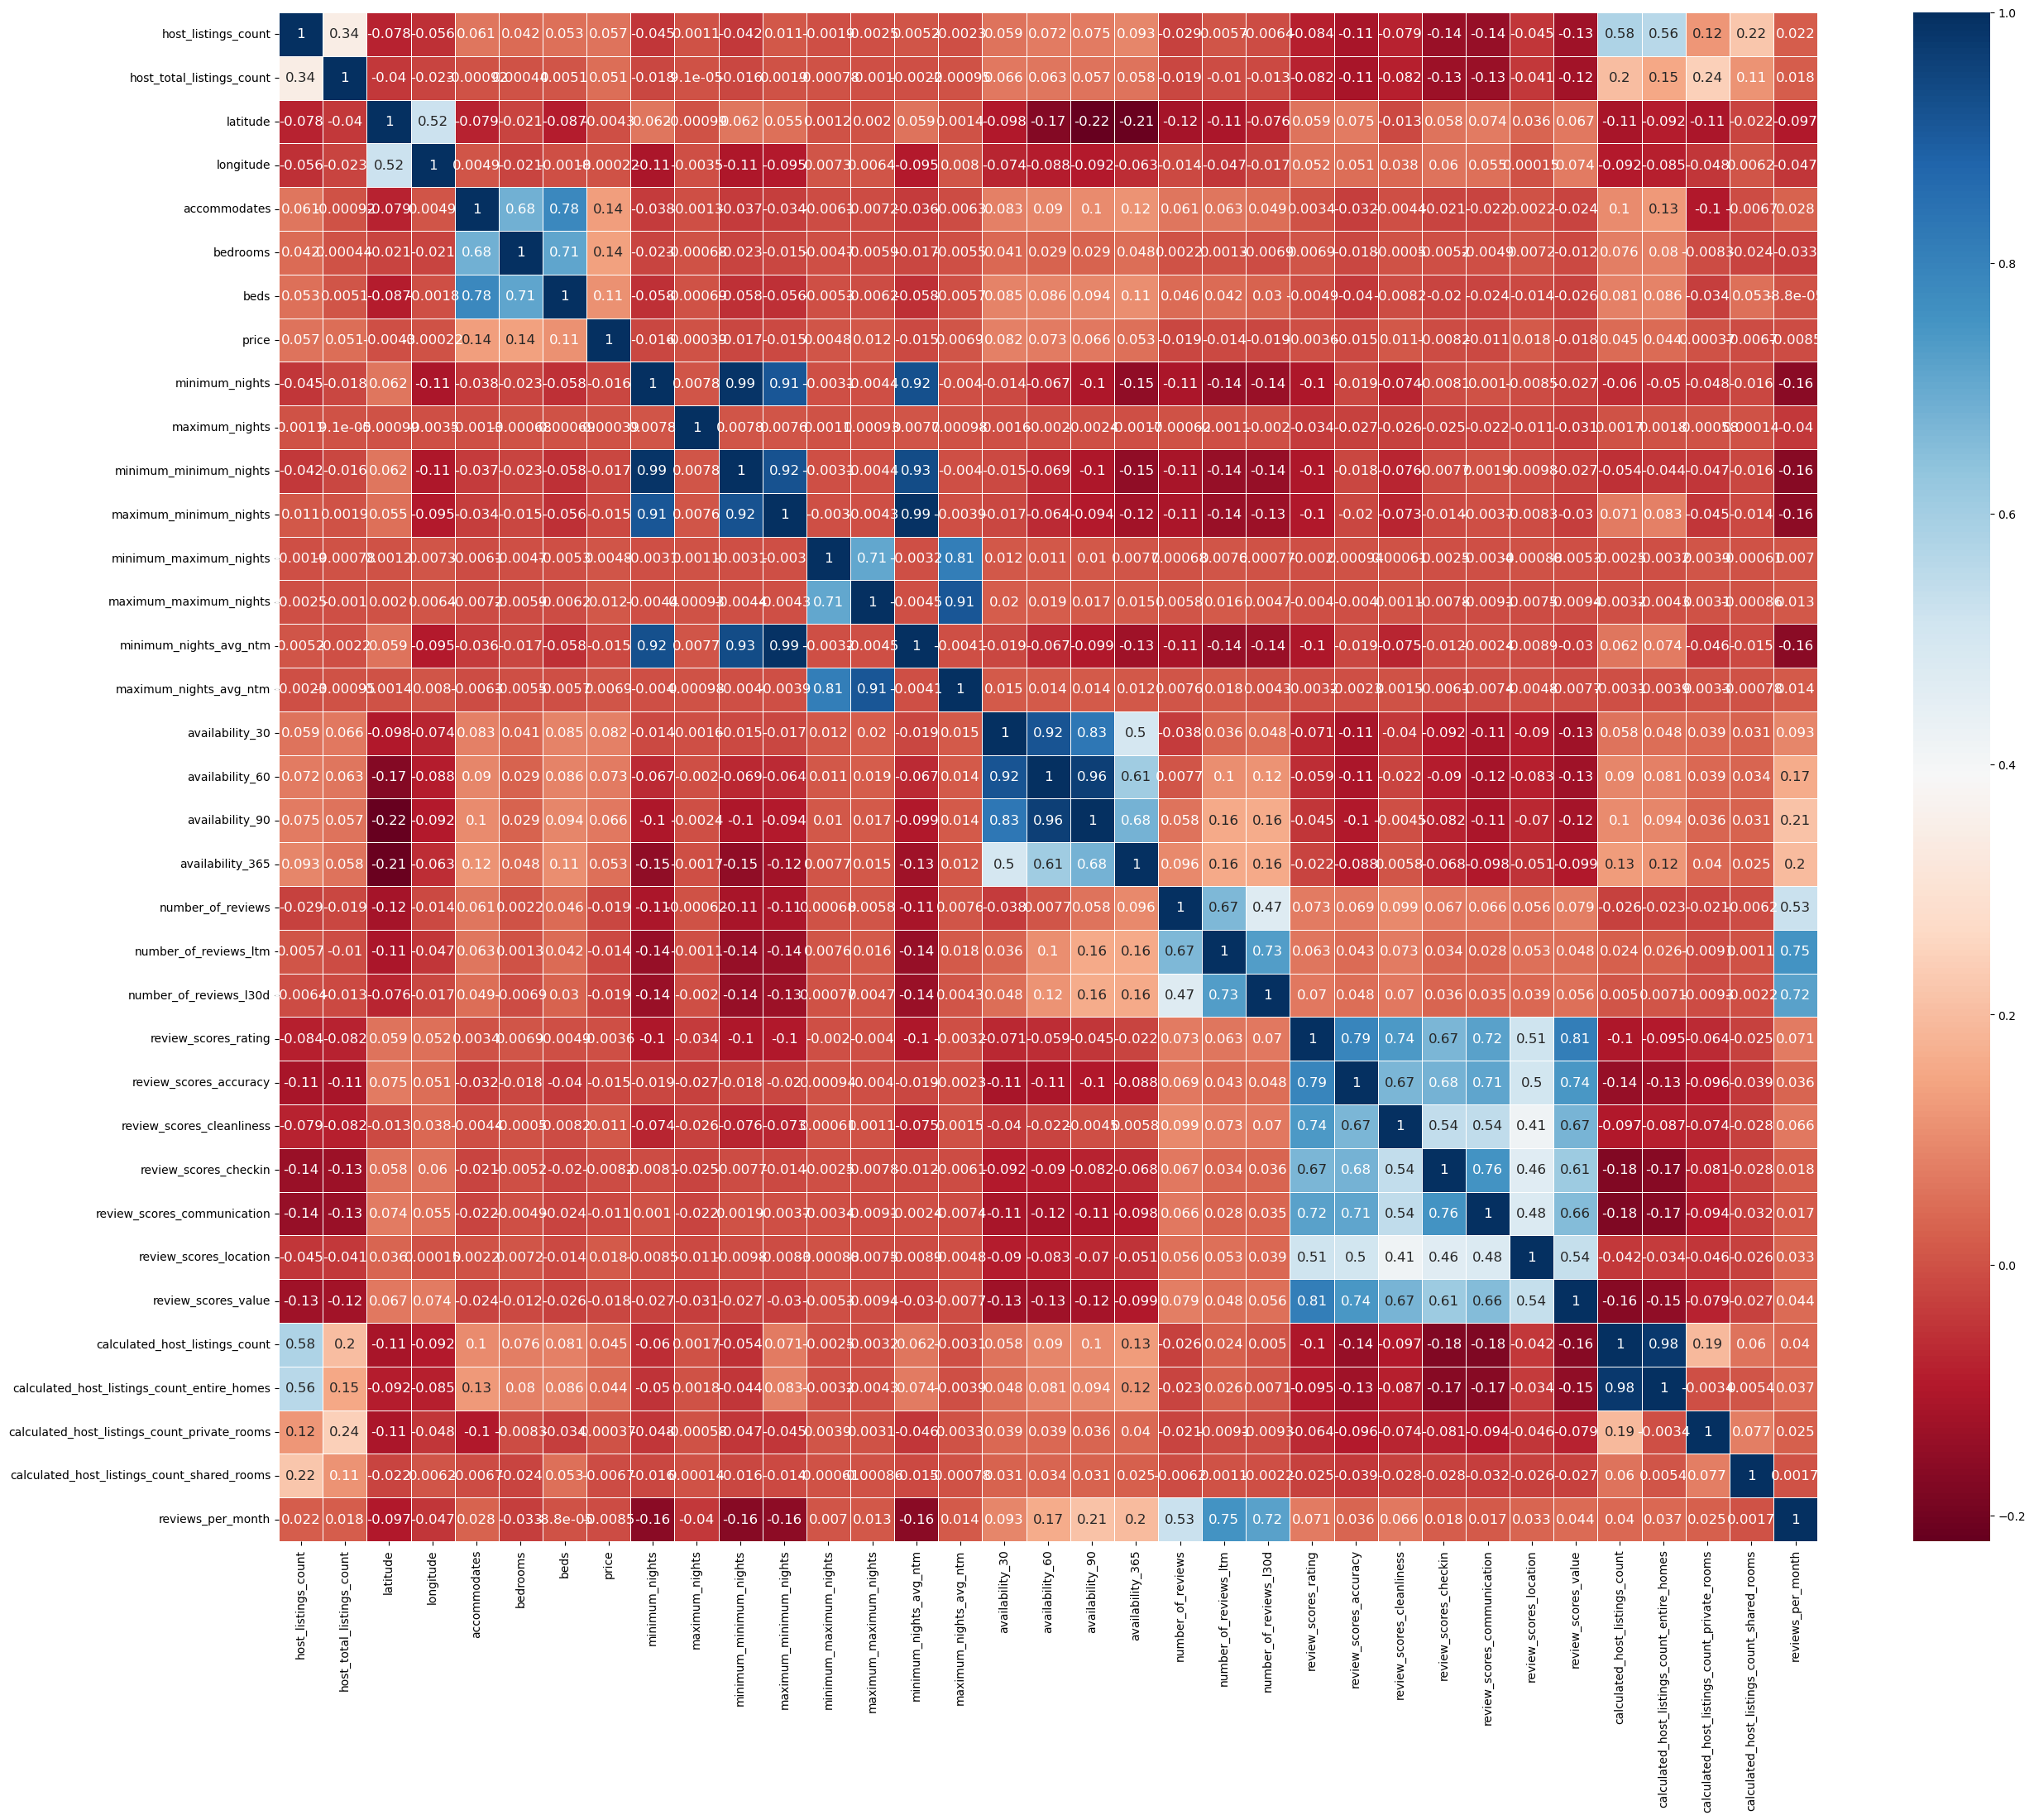

In [18]:
correlation_matrix(df, num_cols)

# Base Model

In [18]:
df_base = df.copy()

In [19]:
df_base.drop(["bathrooms","amenities","host_verifications"], axis=1, inplace=True)

In [20]:
df_base.isnull().sum()

host_response_time                              68028
host_response_rate                              68028
host_acceptance_rate                            56021
host_is_superhost                                 104
host_listings_count                                40
host_total_listings_count                          40
host_has_profile_pic                               40
host_identity_verified                             40
neighbourhood_cleansed                              0
latitude                                            0
longitude                                           0
property_type                                       0
room_type                                           0
accommodates                                        0
bathrooms_text                                    376
bedrooms                                        21831
beds                                             3681
price                                               0
minimum_nights              

In [21]:
df_base.dropna(inplace=True)

In [22]:
df_base.shape

(138465, 48)

In [25]:
cat_cols, num_cols, cat_but_car = grab_col_names(df_base,car_th=1000)
print(f"\nNumerical Columns:{num_cols}\nCategorical Columns:{cat_cols}\nCardinal Columns:{cat_but_car}")

DF_BASE 

Observations: 138465
Variables: 48
cat_cols: 13
num_cols: 35
cat_but_car: 0
num_but_cat: 0

Numerical Columns:['host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month']
Categorical Columns:['host_response

In [26]:
binary_cols = [col for col in df_base.columns if df_base[col].dtypes == "O" and len(df_base[col].unique()) == 2]

In [27]:
binary_cols

['host_is_superhost',
 'host_has_profile_pic',
 'host_identity_verified',
 'has_availability',
 'instant_bookable']

In [28]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe
    
for col in binary_cols:
    label_encoder(df_base, col)

In [29]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df_base = one_hot_encoder(df_base, cat_cols, drop_first=True)

In [30]:
y = df_base["price"]
X = df_base.drop(["price"], axis=1)

In [31]:
X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=42)

In [38]:
models = {
    'LGBM': LGBMRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(random_state=42, verbose=0),
    'Linear Regression': LinearRegression(),
    'KNN': KNeighborsRegressor(),
    'Decision Tree': DecisionTreeRegressor()
}


for model_name, model in models.items():

    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    avg_rmse = np.sqrt(-np.mean(scores))
    

    model.fit(X_train, y_train)
    

    y_pred = model.predict(X_test)
    

    r2 = r2_score(y_test, y_pred)
    

    print(f"Model: {model_name}")
    print(f"Cross-Validation RMSE: {avg_rmse}")
    print(f"R2: {r2}")
    print()


Model: LGBM
Cross-Validation RMSE: 174.56401967277387
R2: 0.37720369893311334

Model: CatBoost
Cross-Validation RMSE: 167.91412189444821
R2: 0.4372926167513963

Model: Linear Regression
Cross-Validation RMSE: 198.6044579416488
R2: 0.18144211831291468

Model: KNN
Cross-Validation RMSE: 199.50706057095596
R2: 0.038917880946112926

Model: Decision Tree
Cross-Validation RMSE: 231.41915443130054
R2: -0.39150098925081456



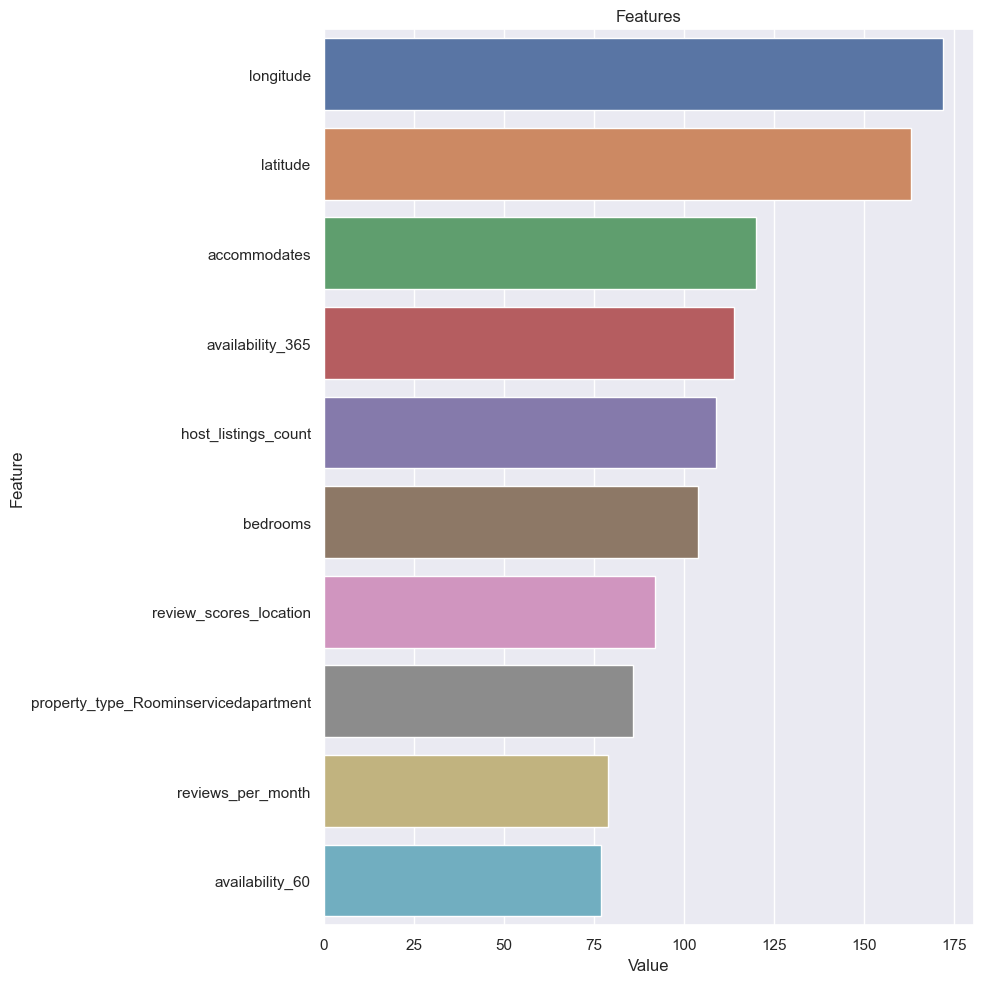

In [42]:
def plot_importance(model, features, num=10, save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(LGBMRegressor(random_state=42).fit(X_train, y_train), X)

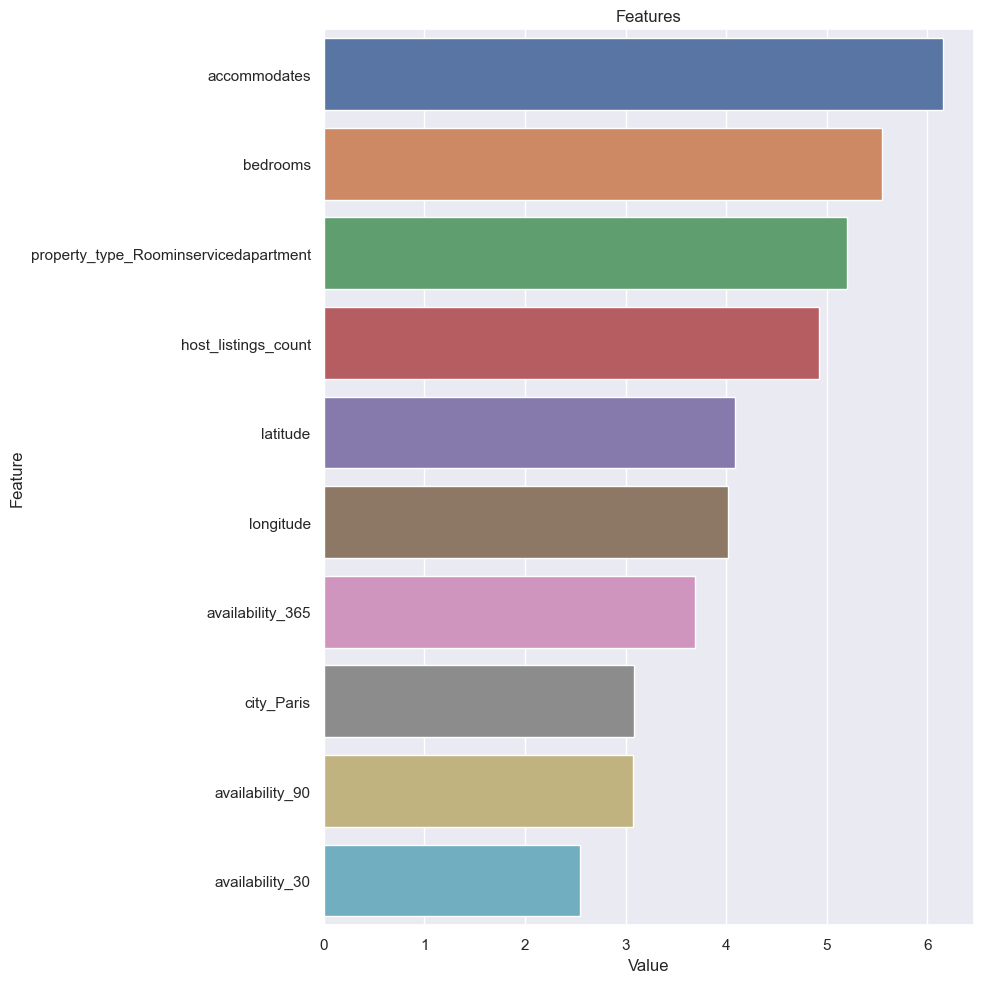

In [44]:
def plot_importance(model, features, num=10, save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(CatBoostRegressor(verbose=False,random_state=42).fit(X_train, y_train), X)

# Sampling

In [19]:
def city_sampler (dataframe, city, sample):
  df_city = dataframe[dataframe["city"] == city] 
  dataframe = dataframe[~(dataframe["city"] == city)]
  df_city = df_city.sample(sample,random_state=42)
  dataframe = pd.concat([dataframe,df_city],ignore_index=True)

  return dataframe

In [20]:
df["city"].value_counts()

Paris         61365
Rome          24782
Madrid        20681
Barcelona     16920
Berlin        16680
Copenhagen    13815
Porto         11804
Vienna        11797
Florence      11138
Lyon          10934
Prague         7537
Amsterdam      6893
Munich         6627
Sevilla        6494
Brussels       6065
Oslo           5371
Stockholm      3990
Zurich         2246
Name: city, dtype: int64

In [21]:
# Paris has too many listings compared to others so a sample of 30K has taken from it 
df = city_sampler(df, "Paris", 30000)

In [22]:
df.reset_index(drop=True,inplace=True)

In [23]:
df.shape

(213774, 51)

In [24]:
df["price"].describe([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])

count   213774.000
mean       148.376
std        517.371
min          0.000
10%         39.000
20%         54.000
30%         68.000
40%         80.000
50%         96.000
60%        115.000
70%        140.000
80%        180.000
90%        261.000
91%        276.000
92%        294.000
93%        309.000
94%        336.143
95%        364.000
96%        403.372
97%        475.000
98%        580.000
99%        859.000
max      91000.000
Name: price, dtype: float64

In [25]:
df = df[(df["price"] > 0) & (df["price"] < 320)]

In [26]:
print('Mean =',df["price"].mean())
print('Std. Dev. =',df["price"].std())

Mean = 106.93007669227823
Std. Dev. = 65.4601305753302


In [27]:
df.shape

(199557, 51)

# Correcting Features

In [28]:
df.drop_duplicates(keep='first' ,inplace=True)

In [29]:
def remove_percentage(dataframe,column):
  dataframe[col] = dataframe[col].apply(lambda x: x.replace("%", "") if pd.notnull(x) else x)
  dataframe[col] = dataframe[col].fillna("-1")
  dataframe[col] = dataframe[col].astype("int")
  dataframe.loc[dataframe[col] == -1, col] = np.nan 

for col in ["host_response_rate","host_acceptance_rate"]:
  remove_percentage(df,col)

In [30]:
df["property_type"] = df["property_type"].apply(lambda x: x.lower())

In [31]:
property_list = ["rental unit", "condo", "loft", "apartment", "bed and breakfast", "boutique hotel", "townhouse", "vacation", "hostel", "villa",
                 "casa particular", "guest suite", "guesthouse", "aparthotel" ,"tiny home", "houseboat", "camper/rv", "cottage", "bungalow",
                 "floor", "lodge", "hut", "earthen", "tent", "minsu", "resort", "cabin", "chalet", "farm stay",
                 "pension", "barn", "castle", "tower", "cave", "tipi", "bus", "island", "treehouse", "ryokan", "heritage hotel", "in-law"
                 "ice dome", "lighthouse", "religious building", "kezhan", "trullo", "train", "container", "windmill", "in-law"]

In [32]:
for row in property_list:
  df["property_type"] = df["property_type"].apply(lambda x: row if row in x else x)

In [33]:
df.loc[(df["property_type"] == "entire home") | (df["property_type"] == "entire home/apt") | (df["property_type"] == "shared room in home") | (df["property_type"] == "private room in home"), "property_type"] = "home"
df.loc[(df["property_type"] == "room in hotel") | (df["property_type"] == "shared room in hotel"), "property_type"] = "hotel"
df.loc[(df["property_type"] == "private room") | (df["property_type"] == "shared room"), "property_type"] = "room"
df.loc[(df["property_type"] == "boat") | (df["property_type"] == "private room in boat") | (df["property_type"] == "shared room in boat"), "property_type"] = "boat"
df.loc[(df["property_type"] == "private room in dome") | (df["property_type"] == "shared room in dome"), "property_type"] = "dome"
df.loc[(df["property_type"] == "private room in ice dome") | (df["property_type"] == "shared room in ice dome"), "property_type"] = "dome"
df["property_type"] = df["property_type"].apply(lambda x: "hotel" if "hotel" in x else x)
df["property_type"] = df["property_type"].apply(lambda x: "hotel" if "hostel" in x else x)
df["property_type"] = df["property_type"].apply(lambda x: "farm" if "farm" in x else x)

In [34]:
df["property_type"].value_counts()

rental unit           139342
condo                  24538
home                    7697
hotel                   5112
loft                    5005
apartment               4796
bed and breakfast       3957
townhouse               2201
villa                   1113
vacation                 979
guest suite              964
guesthouse               897
casa particular          678
tiny home                333
boat                     295
room                     271
houseboat                270
camper/rv                141
entire place             136
cottage                  136
bungalow                 106
chalet                   103
farm                      80
cabin                     77
floor                     34
pension                   31
earthen                   29
lodge                     23
tent                      21
hut                       21
dome                      20
castle                    15
barn                      14
minsu                      8
tipi          

# Filling NA Values

In [35]:
drop_list = ["host_response_time","host_is_superhost","host_verifications","host_has_profile_pic", "host_identity_verified", "has_availability"]
df.drop(drop_list, axis=1, inplace=True)

In [36]:
df.isnull().sum()

host_response_rate                               52629
host_acceptance_rate                             42302
host_listings_count                                 34
host_total_listings_count                           34
neighbourhood_cleansed                               0
latitude                                             0
longitude                                            0
property_type                                        0
room_type                                            0
accommodates                                         0
bathrooms                                       199499
bathrooms_text                                     190
bedrooms                                         16213
beds                                              2848
amenities                                            0
price                                                0
minimum_nights                                       0
maximum_nights                                       0
minimum_mi

In [37]:
df['host_response_rate'] = df['host_response_rate'].fillna(df['host_response_rate'].median())
df['host_acceptance_rate'] = df['host_acceptance_rate'].fillna(df['host_acceptance_rate'].median())
df['host_listings_count'] = df['host_listings_count'].fillna(df['host_listings_count'].median())
df['host_total_listings_count'] = df['host_total_listings_count'].fillna(df['host_total_listings_count'].median())

In [38]:
for i in ['minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm']:
    df[i] = df[i].fillna(df[i].median()) 

In [39]:
for i in ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']:
    df[i] = df[i].fillna(df[i].mean()) 

In [40]:
df['reviews_per_month'] = df['reviews_per_month'].fillna(df['reviews_per_month'].median())

# Filling Bedroom Data

In [41]:
grouped = df.groupby(['property_type', 'room_type'])
mean_bedrooms = grouped['bedrooms'].transform('median')
df['bedrooms'] = df['bedrooms'].fillna(mean_bedrooms)

In [42]:
grouped = df.groupby(['property_type', 'room_type'])
mean_beds = grouped['beds'].transform('median')
df['beds'] = df['beds'].fillna(mean_beds)

In [43]:
df.isnull().sum()

host_response_rate                                   0
host_acceptance_rate                                 0
host_listings_count                                  0
host_total_listings_count                            0
neighbourhood_cleansed                               0
latitude                                             0
longitude                                            0
property_type                                        0
room_type                                            0
accommodates                                         0
bathrooms                                       199499
bathrooms_text                                     190
bedrooms                                             0
beds                                                 0
amenities                                            0
price                                                0
minimum_nights                                       0
maximum_nights                                       0
minimum_mi

# Filling Bathroom Data

In [44]:
def extract_number(text):
  if text is None or pd.isnull(text):
    return text
  else:
    number = (text.split(" ")[0])
    try:
      return float(number)
    except ValueError:
      return 0.5

In [45]:
df['bathrooms'] = df['bathrooms_text'].apply(extract_number)

In [46]:
bath_amenities = ["hair dryer","shampoo","body soap","hot water", "shower gel","conditioner","bidet","shower","hot tub"]

In [47]:
import ast

df["amenities"] = df["amenities"].apply(lambda x: x.lower())
df["amenities"] = df["amenities"].apply(lambda x: ast.literal_eval(x))

In [48]:
for index, value in df.loc[df["bathrooms_text"].isna(),"amenities"].iteritems():
    result = any(item in value for item in bath_amenities)
    if result == True:
       df.loc[index, 'bathrooms'] = 1
    else:
        df.loc[index, 'bathrooms'] = 0

In [49]:
def check_shared(string):
    if 'shared' in string:
        return 'shared'
    else:
        return 'private'

df['bathrooms_type'] = df[pd.notnull(df['bathrooms_text'])]['bathrooms_text'].apply(check_shared)

In [50]:
df['bathrooms_type'] = df['bathrooms_type'].fillna(df['bathrooms_type'].mode()[0])

In [51]:
df.drop("bathrooms_text",axis=1,inplace=True)

In [52]:
df.isnull().sum()

host_response_rate                              0
host_acceptance_rate                            0
host_listings_count                             0
host_total_listings_count                       0
neighbourhood_cleansed                          0
latitude                                        0
longitude                                       0
property_type                                   0
room_type                                       0
accommodates                                    0
bathrooms                                       0
bedrooms                                        0
beds                                            0
amenities                                       0
price                                           0
minimum_nights                                  0
maximum_nights                                  0
minimum_minimum_nights                          0
maximum_minimum_nights                          0
minimum_maximum_nights                          0


In [53]:
df.head()

,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,city,bathrooms_type
0,100.000,100.000,1.000,1.000,Oostelijk Havengebied - Indische Buurt,52.364,4.944,rental unit,Private room,2,1.500,1.000,2.000,"[fire extinguisher, private entrance, laundrom...",49.000,3,28,3.000,3.000,1125.000,1125.000,3.000,1125.000,1,9,14,14,305,25,1,4.890,4.940,5.000,4.970,4.980,4.690,4.820,t,1,0,1,0,1.860,Amsterdam,shared
1,100.000,98.000,5.000,5.000,Centrum-Oost,52.364,4.894,townhouse,Private room,2,1.000,1.000,1.000,"[wifi, refrigerator, tv, fire extinguisher, he...",106.000,1,365,1.000,1.000,1125.000,1125.000,1.000,1125.000,0,0,0,0,339,0,0,4.440,4.690,4.790,4.630,4.620,4.870,4.490,t,2,0,2,0,2.220,Amsterdam,private
2,100.000,100.000,1.000,1.000,Centrum-West,52.388,4.892,houseboat,Private room,2,1.500,1.000,1.000,"[safe, fire extinguisher, hp neutral, eco frie...",136.000,2,356,2.000,2.000,1125.000,1125.000,2.000,1125.000,0,0,14,121,231,8,0,4.940,4.920,4.950,4.950,4.920,4.890,4.790,t,1,0,1,0,1.780,Amsterdam,private
3,100.000,100.000,2.000,2.000,Centrum-West,52.368,4.891,rental unit,Private room,2,1.000,1.000,1.000,"[wifi, shampoo, refrigerator, iron, fire extin...",75.000,2,1825,2.000,2.000,1825.000,1825.000,2.000,1825.000,4,6,8,117,428,75,5,4.880,4.940,4.890,4.960,4.940,4.960,4.830,f,2,0,2,0,2.920,Amsterdam,shared
4,100.000,100.000,2.000,2.000,Centrum-Oost,52.366,4.891,rental unit,Private room,1,1.000,1.000,1.000,"[wifi, shampoo, refrigerator, iron, fire extin...",55.000,2,730,2.000,2.000,730.000,730.000,2.000,730.000,0,4,5,160,582,86,7,4.790,4.880,4.840,4.920,4.920,4.870,4.770,f,2,0,2,0,4.160,Amsterdam,shared


# Outlier Analysis

In [54]:
def outlier_thresholds(dataframe, col_name, q1=0.01, q3=0.99):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [55]:
def check_outlier(dataframe, col_name, q1=0.01, q3=0.99):
    print("\n")
    print('\033[1m' +f'{col_name.upper()}'.center(30, '-')+'\033[0m')
    print(f"Max Value = {dataframe[col_name].max()}, Min Value = {dataframe[col_name].min()}")
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    print(f"Lower limit = {low_limit}, Upper limit = {up_limit}")
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [56]:
df_temp = df.drop('amenities', axis=1)

In [57]:
cat_cols, num_cols, cat_but_car = grab_col_names(df_temp)
print(f"\nNumerical Columns: {num_cols}")

DF_TEMP 

Observations: 199499
Variables: 44
cat_cols: 5
num_cols: 38
cat_but_car: 1
num_but_cat: 0

Numerical Columns: ['host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms

In [58]:
for col in num_cols:
    print(check_outlier(df,col))



------HOST_RESPONSE_RATE------
Max Value = 100.0, Min Value = 0.0
Lower limit = -150.0, Upper limit = 250.0
False


-----HOST_ACCEPTANCE_RATE-----
Max Value = 100.0, Min Value = 0.0
Lower limit = -150.0, Upper limit = 250.0
False


-----HOST_LISTINGS_COUNT------
Max Value = 1732.0, Min Value = 0.0
Lower limit = -392.0, Upper limit = 656.0
True


--HOST_TOTAL_LISTINGS_COUNT---
Max Value = 12017.0, Min Value = 0.0
Lower limit = -567.5, Upper limit = 948.5
True


-----------LATITUDE-----------
Max Value = 60.03894, Min Value = 37.31020112444731
Lower limit = 3.5788247600000034, Upper limit = 93.73478539999999
False


----------LONGITUDE-----------
Max Value = 18.2114718, Min Value = -8.78297
Lower limit = -48.64218794, Upper limit = 58.04862949999999
False


---------ACCOMMODATES---------
Max Value = 16, Min Value = 1
Lower limit = -9.5, Upper limit = 18.5
False


----------BATHROOMS-----------
Max Value = 50.0, Min Value = 0.0
Lower limit = -2.0, Upper limit = 6.0
True


-----------BED

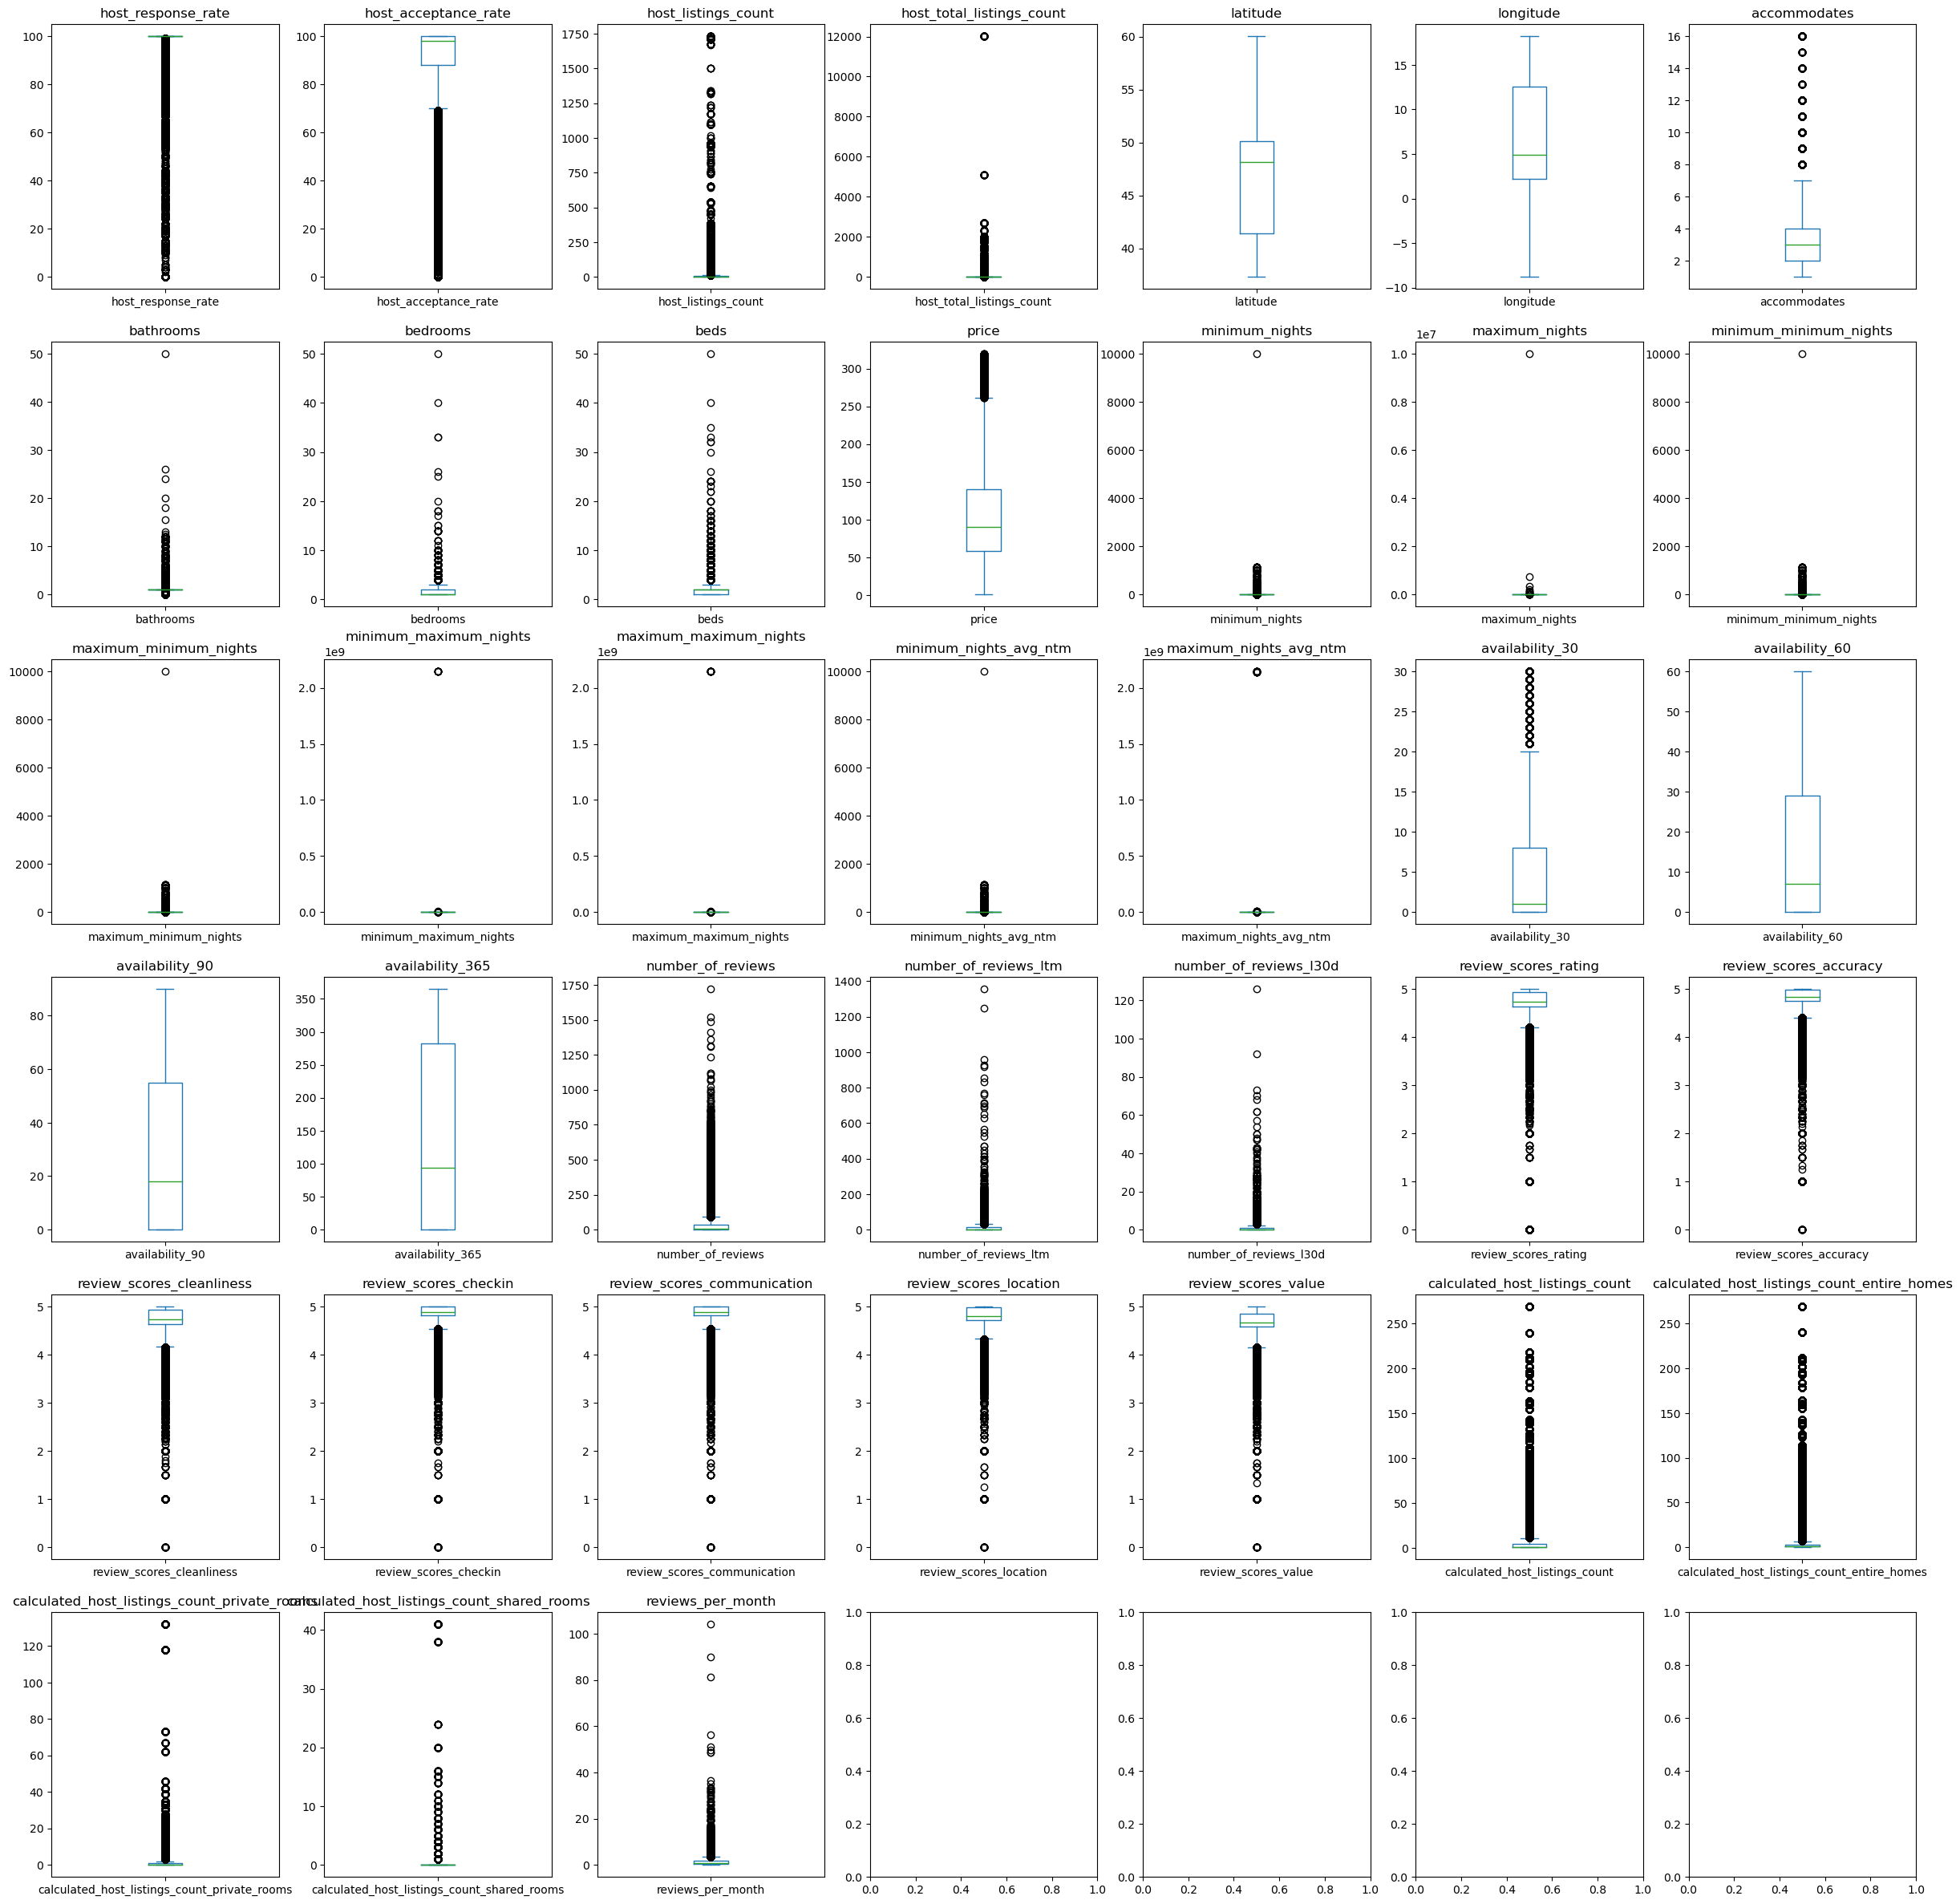

In [59]:
fig, axs = plt.subplots(6, 7, figsize=(30,30), sharey=False)
for i, j in enumerate(num_cols):
  row = i // 7
  col = i % 7
  df[j].plot(kind='box', ax=axs[row, col])
  axs[row, col].set_title(j)

plt.show()

In [60]:
print(df[df["host_total_listings_count"] > 2500].shape)
print(df[df["bedrooms"] > 30].shape)
print(df[df["bathrooms"] > 30].shape)
print(df[df["beds"] > 40].shape)
#print(df[df["number_of_reviews"] > 2000].shape)
print(df[df["number_of_reviews_ltm"] > 1000].shape)
print(df[df["number_of_reviews_l30d"] > 80].shape)
print(df[df["calculated_host_listings_count"] > 250].shape)
print(df[df["calculated_host_listings_count_entire_homes"] > 250].shape)
print(df[df["calculated_host_listings_count_private_rooms"] > 80].shape)
print(df[df["calculated_host_listings_count_shared_rooms"] > 25].shape)
print(df[df["reviews_per_month"] > 60].shape)

(179, 45)
(4, 45)
(1, 45)
(1, 45)
(2, 45)
(2, 45)
(139, 45)
(139, 45)
(250, 45)
(136, 45)
(3, 45)


In [61]:
df = df[df["host_total_listings_count"] <= 2500]
df = df[df["bedrooms"] <= 30]
df = df[df["beds"] <= 40]
df = df[df["number_of_reviews"] <= 2000]
df = df[df["number_of_reviews_ltm"] <= 1000]
df = df[df["number_of_reviews_l30d"] <= 80]
df = df[df["calculated_host_listings_count"] <= 250]
df = df[df["calculated_host_listings_count_entire_homes"] <= 250]
df = df[df["calculated_host_listings_count_private_rooms"] <= 80]
df = df[df["calculated_host_listings_count_shared_rooms"] <= 25]
df = df[df["reviews_per_month"] <= 60]

In [62]:
df[['minimum_nights',
 'maximum_nights',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm']].describe([0.50,0.51,0.52,0.53,0.54,0.55,0.60,0.70, 0.75,0.80,0.85,0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99]).T

,count,mean,std,min,50%,51%,52%,53%,54%,55%,60%,70%,75%,80%,85%,90%,91%,92%,93%,94%,95%,96%,97%,98%,99%,max
minimum_nights,198873.000,22.100,80.426,1.000,2.000,2.000,2.000,2.000,2.000,2.000,3.000,3.000,4.000,5.000,7.000,30.000,30.000,31.000,32.000,60.000,92.000,365.000,365.000,365.000,365.000,9999.000
maximum_nights,198873.000,653.590,22509.893,1.000,365.000,365.000,365.000,365.000,500.000,1124.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,10000000.000
minimum_minimum_nights,198873.000,21.801,80.162,1.000,2.000,2.000,2.000,2.000,2.000,2.000,3.000,3.000,4.000,5.000,7.000,30.000,30.000,31.000,32.000,56.000,92.000,365.000,365.000,365.000,365.000,9999.000
maximum_minimum_nights,198873.000,24.742,87.611,1.000,3.000,3.000,3.000,3.000,3.000,3.000,3.000,4.000,5.000,6.000,10.000,30.000,31.000,32.000,33.000,90.000,123.400,365.000,365.000,365.000,365.000,9999.000
minimum_maximum_nights,198873.000,87144.264,13620082.641,1.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,2147483647.000
maximum_maximum_nights,198873.000,184373.799,19854047.618,1.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,2147483647.000
minimum_nights_avg_ntm,198873.000,23.849,86.121,1.000,2.100,2.200,2.400,2.700,3.000,3.000,3.000,3.700,4.000,5.000,8.000,30.000,30.000,31.000,32.000,62.000,120.000,365.000,365.000,365.000,365.000,9999.000
maximum_nights_avg_ntm,198873.000,151882.877,17999943.822,1.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,1125.000,2147483647.000


In [63]:
for i in ['minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm']:
    print(df.loc[df[i] > df[i].quantile(0.99)].shape)

(113, 45)
(49, 45)
(126, 45)
(568, 45)
(62, 45)
(122, 45)
(539, 45)
(122, 45)


In [64]:
for i in ['minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm']:
    df.loc[df[i] > df[i].quantile(0.99), i] = df[i].quantile(0.99) 

In [65]:
for col in num_cols:
    print(check_outlier(df,col))



------HOST_RESPONSE_RATE------
Max Value = 100.0, Min Value = 0.0
Lower limit = -150.0, Upper limit = 250.0
False


-----HOST_ACCEPTANCE_RATE-----
Max Value = 100.0, Min Value = 0.0
Lower limit = -150.0, Upper limit = 250.0
False


-----HOST_LISTINGS_COUNT------
Max Value = 1732.0, Min Value = 0.0
Lower limit = -360.5, Upper limit = 603.5
True


--HOST_TOTAL_LISTINGS_COUNT---
Max Value = 2344.0, Min Value = 0.0
Lower limit = -512.0, Upper limit = 856.0
True


-----------LATITUDE-----------
Max Value = 60.03894, Min Value = 37.31020112444731
Lower limit = 3.5787508000000017, Upper limit = 93.734882
False


----------LONGITUDE-----------
Max Value = 18.2114718, Min Value = -8.78297
Lower limit = -48.6426918, Upper limit = 58.04876899999999
False


---------ACCOMMODATES---------
Max Value = 16, Min Value = 1
Lower limit = -9.5, Upper limit = 18.5
False


----------BATHROOMS-----------
Max Value = 26.0, Min Value = 0.0
Lower limit = -2.0, Upper limit = 6.0
True


-----------BEDROOMS-----

In [66]:
df.shape

(198873, 45)

# Model (No New Features)

In [371]:
model = df.copy()

In [372]:
model.drop("amenities", axis=1, inplace=True)

In [373]:
model.isnull().sum()

host_response_rate                              0
host_acceptance_rate                            0
host_listings_count                             0
host_total_listings_count                       0
neighbourhood_cleansed                          0
latitude                                        0
longitude                                       0
property_type                                   0
room_type                                       0
accommodates                                    0
bathrooms                                       0
bedrooms                                        0
beds                                            0
price                                           0
minimum_nights                                  0
maximum_nights                                  0
minimum_minimum_nights                          0
maximum_minimum_nights                          0
minimum_maximum_nights                          0
maximum_maximum_nights                          0


In [374]:
model.shape

(198873, 44)

In [375]:
model.head()

,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,city,bathrooms_type
0,100.000,100.000,1.000,1.000,Oostelijk Havengebied - Indische Buurt,52.364,4.944,rental unit,Private room,2,1.500,1.000,2.000,49.000,3,28,3.000,3.000,1125.000,1125.000,3.000,1125.000,1,9,14,14,305,25,1,4.890,4.940,5.000,4.970,4.980,4.690,4.820,t,1,0,1,0,1.860,Amsterdam,shared
1,100.000,98.000,5.000,5.000,Centrum-Oost,52.364,4.894,townhouse,Private room,2,1.000,1.000,1.000,106.000,1,365,1.000,1.000,1125.000,1125.000,1.000,1125.000,0,0,0,0,339,0,0,4.440,4.690,4.790,4.630,4.620,4.870,4.490,t,2,0,2,0,2.220,Amsterdam,private
2,100.000,100.000,1.000,1.000,Centrum-West,52.388,4.892,houseboat,Private room,2,1.500,1.000,1.000,136.000,2,356,2.000,2.000,1125.000,1125.000,2.000,1125.000,0,0,14,121,231,8,0,4.940,4.920,4.950,4.950,4.920,4.890,4.790,t,1,0,1,0,1.780,Amsterdam,private
3,100.000,100.000,2.000,2.000,Centrum-West,52.368,4.891,rental unit,Private room,2,1.000,1.000,1.000,75.000,2,1125,2.000,2.000,1125.000,1125.000,2.000,1125.000,4,6,8,117,428,75,5,4.880,4.940,4.890,4.960,4.940,4.960,4.830,f,2,0,2,0,2.920,Amsterdam,shared
4,100.000,100.000,2.000,2.000,Centrum-Oost,52.366,4.891,rental unit,Private room,1,1.000,1.000,1.000,55.000,2,730,2.000,2.000,730.000,730.000,2.000,730.000,0,4,5,160,582,86,7,4.790,4.880,4.840,4.920,4.920,4.870,4.770,f,2,0,2,0,4.160,Amsterdam,shared


In [376]:
cat_cols, num_cols, cat_but_car = grab_col_names(model,car_th=1000)
print(f"\nNumerical Columns:{num_cols}\nCategorical Columns:{cat_cols}\nCardinal Columns:{cat_but_car}")

MODEL 

Observations: 198873
Variables: 44
cat_cols: 6
num_cols: 38
cat_but_car: 0
num_but_cat: 0

Numerical Columns:['host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 

In [377]:
binary_cols = [col for col in model.columns if model[col].dtypes == "O" and len(model[col].unique()) == 2]

In [378]:
binary_cols

['instant_bookable', 'bathrooms_type']

In [379]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe
    
for col in binary_cols:
    label_encoder(model, col)

In [380]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

model = one_hot_encoder(model, cat_cols, drop_first=True)

In [381]:
y = model["price"]
X = model.drop(["price"], axis=1)

In [382]:
X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [383]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=42)

In [384]:
models = {
    'LGBM': LGBMRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(random_state=42, verbose=0),
    'Linear Regression': LinearRegression(),
    'KNN': KNeighborsRegressor(),
    'Decision Tree': DecisionTreeRegressor()
}


for model_name, model in models.items():

    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    avg_rmse = np.sqrt(-np.mean(scores))
    

    model.fit(X_train, y_train)
    

    y_pred = model.predict(X_test)
    

    r2 = r2_score(y_test, y_pred)
    

    print(f"Model: {model_name}")
    print(f"Cross-Validation RMSE: {avg_rmse}")
    print(f"R2: {r2}")
    print()


Model: LGBM
Cross-Validation RMSE: 40.09356168680263
R2: 0.6325294728066913

Model: CatBoost
Cross-Validation RMSE: 38.16734570278478
R2: 0.6698006877559183

Model: Linear Regression
Cross-Validation RMSE: 45.93927795490788
R2: -607926413873.6243

Model: KNN
Cross-Validation RMSE: 57.86905490198668
R2: 0.23657519646083713

Model: Decision Tree
Cross-Validation RMSE: 56.3179675195314
R2: 0.2819414060583253



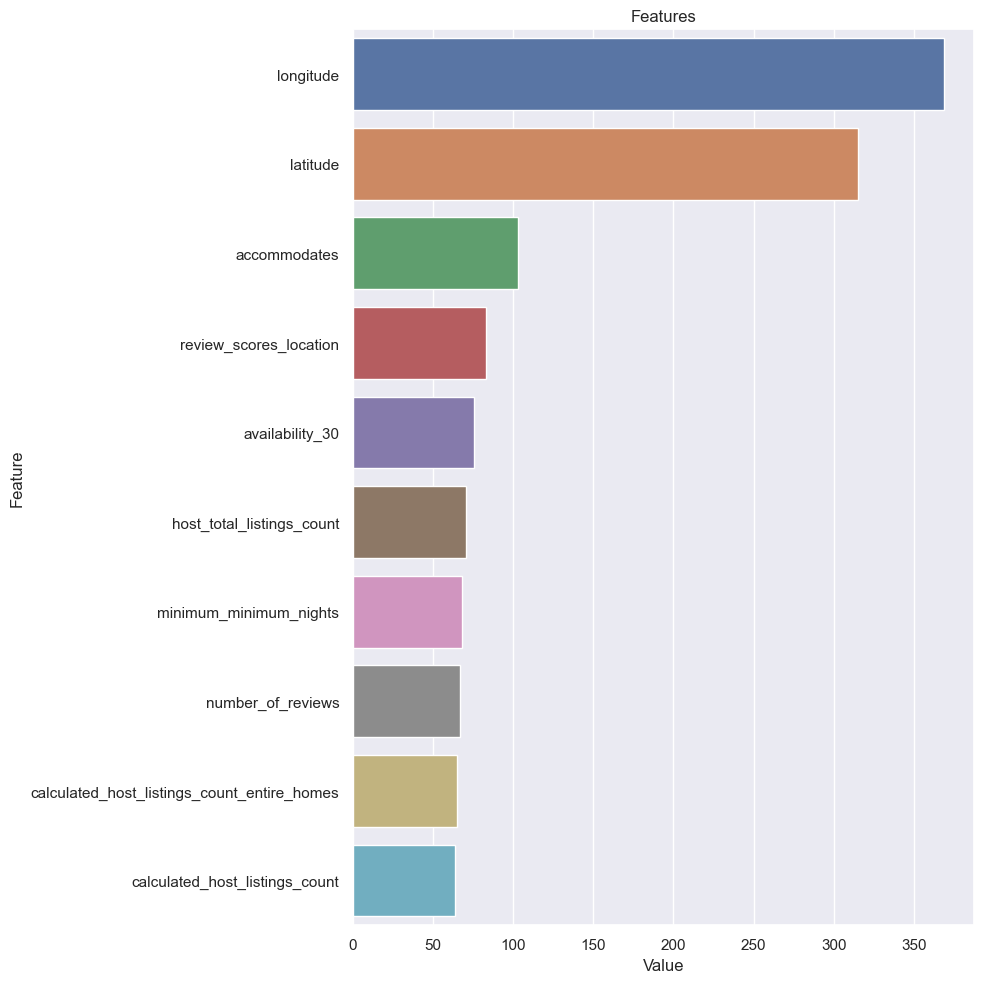

In [385]:
def plot_importance(model, features, num=10, save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(LGBMRegressor(random_state=42).fit(X_train, y_train), X)

# Distance from City Center Calculations

In [8]:
city_centers = pd.read_csv("Datasets/city_center.csv")

In [68]:
df.reset_index(drop=True,inplace=True)

In [69]:
city_centers.head()

,city,lat,lon
0,Copenhagen,55.676,12.566
1,Amsterdam,52.374,4.890
2,Barcelona,41.389,2.159
3,Lyon,45.748,4.847
4,Oslo,59.913,10.746


In [70]:
df_merged = pd.merge(df, city_centers, on='city',how="left")

In [71]:
from math import radians, degrees, sin, cos, asin, acos, sqrt
def great_circle(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    return 6371 * (
        acos(sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(lon1 - lon2))
    )


In [72]:
df_merged['center_distance'] = df_merged.apply(lambda row: great_circle(row['longitude'], row['latitude'], row['lon'], row['lat']),axis=1)

In [73]:
df['NEW_center_distance'] = df_merged['center_distance']

In [74]:
df['NEW_center_distance'].describe([0.50,0.51,0.52,0.53,0.54,0.55,0.60,0.70, 0.75,0.80,0.85,0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99]).T

count   198873.000
mean        66.574
std        254.127
min          0.000
50%          2.754
51%          2.818
52%          2.880
53%          2.945
54%          3.013
55%          3.083
60%          3.417
70%          4.190
75%          4.697
80%          5.358
85%          6.439
90%          8.946
91%         10.301
92%         12.740
93%         19.024
94%         30.813
95%       1087.075
96%       1088.222
97%       1089.236
98%       1090.378
99%       1091.539
max       1103.852
Name: NEW_center_distance, dtype: float64

In [75]:
bins = [-1, 1, 2, 4, 8, 15,30, 1200]
category = ['cok yakin', 'yakin', 'biraz yakin', "orta", "biraz uzak", "uzak", "cok uzak"]
df['NEW_center_distance_cat'] = pd.cut(df['NEW_center_distance'], bins, labels = category)

In [76]:
df['NEW_center_distance_cat'].value_counts()

biraz yakin    63404
yakin          43461
orta           41349
cok yakin      28167
cok uzak       11974
biraz uzak      7571
uzak            2947
Name: NEW_center_distance_cat, dtype: int64

# Final Model Preprocessing

In [77]:
df_final = df.copy()

In [78]:
df_final['NEW_totalrooms'] = df_final['bedrooms'] + df_final['bathrooms']
df_final['NEW_amenities_length'] = df_final['amenities'].apply (lambda x: len(x)) 

In [79]:
df_final["NEW_review_avg"] = (df_final["review_scores_rating"] + df_final["review_scores_accuracy"] + df_final["review_scores_cleanliness"] + df_final["review_scores_checkin"] + df_final["review_scores_communication"] + df_final["review_scores_location"] + df_final["review_scores_value"]) / 7 

In [80]:
drop_list = ['neighbourhood_cleansed',"amenities", 'minimum_nights', 'maximum_nights',
             'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights',
             'maximum_maximum_nights', 'number_of_reviews_l30d',
             'calculated_host_listings_count_entire_homes',
             'calculated_host_listings_count_private_rooms',
             'calculated_host_listings_count_shared_rooms'] 

In [81]:
df_final.drop(drop_list, axis=1, inplace = True)

In [82]:
cat_cols, num_cols, cat_but_car = grab_col_names(df_final,car_th=135)
print(f"\nNumerical Columns:{num_cols}\nCategorical Columns:{cat_cols}\nCardinal Columns:{cat_but_car}")

DF_FINAL 

Observations: 198873
Variables: 38
cat_cols: 6
num_cols: 32
cat_but_car: 0
num_but_cat: 1

Numerical Columns:['host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'reviews_per_month', 'NEW_center_distance', 'NEW_totalrooms', 'NEW_amenities_length', 'NEW_review_avg']
Categorical Columns:['property_type', 'room_type', 'instant_bookable', 'city', 'bathrooms_type', 'NEW_center_distance_cat']
Cardinal Columns:[]


In [83]:
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        df = pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                   "RATIO": 100 * dataframe[col].value_counts() / len(dataframe),
                   "TARGET_MEAN": dataframe.groupby(col)[target].mean(),
                   "TARGET_MIN": dataframe.groupby(col)[target].min(),
                   "TARGET_MAX": dataframe.groupby(col)[target].max()})
        df = df.sort_values("COUNT", ascending=False)
        print(df)
        print("\n\n")

rare_analyser(df_final,"price", cat_cols)

property_type : 54
                     COUNT  RATIO  TARGET_MEAN  TARGET_MIN  TARGET_MAX
rental unit         138826 69.806      101.841       8.000     319.609
condo                24538 12.339      118.486       9.000     319.000
home                  7695  3.869      105.601       8.000     319.528
hotel                 5057  2.543      152.005      10.000     319.035
loft                  5005  2.517      110.994       9.000     318.000
apartment             4793  2.410      145.304      10.000     319.000
bed and breakfast     3947  1.985      104.272      10.000     319.000
townhouse             2201  1.107      121.102      12.000     318.000
villa                 1113  0.560      140.048      13.000     318.000
vacation               979  0.492      118.334      10.000     317.000
guest suite            964  0.485       84.660      10.000     310.000
guesthouse             859  0.432       86.743      13.000     314.000
casa particular        678  0.341       59.945       9.000

In [84]:
mask = df_final["property_type"].map(df_final["property_type"].value_counts()< 3957) 
df_final["property_type"] =  df_final["property_type"].mask(mask, 'Other')

In [85]:
mask = df_final["room_type"].map(df_final["room_type"].value_counts()) < 3000
df_final["room_type"] =  df_final["room_type"].mask(mask, 'Other')

In [ ]:
df_final.to_csv('df_final.csv',index=False)

In [86]:
binary_cols = [col for col in df_final.columns if df_final[col].dtypes == "O" and len(df_final[col].unique()) == 2]

In [87]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe
    
for col in binary_cols:
    label_encoder(df_final, col)

In [88]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df_final = one_hot_encoder(df_final, cat_cols, drop_first=True)

In [89]:
df_final.dtypes

host_response_rate                     float64
host_acceptance_rate                   float64
host_listings_count                    float64
host_total_listings_count              float64
latitude                               float64
longitude                              float64
accommodates                             int64
bathrooms                              float64
bedrooms                               float64
beds                                   float64
price                                  float64
minimum_nights_avg_ntm                 float64
maximum_nights_avg_ntm                 float64
availability_30                          int64
availability_60                          int64
availability_90                          int64
availability_365                         int64
number_of_reviews                        int64
number_of_reviews_ltm                    int64
review_scores_rating                   float64
review_scores_accuracy                 float64
review_scores

# Final Model

In [90]:
y = df_final["price"]
X = df_final.drop(["price"], axis=1) 

In [91]:
X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [417]:
models = {
    'LGBM': LGBMRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(random_state=42, verbose=0),
}


for model_name, model in models.items():

    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    avg_rmse = np.sqrt(-np.mean(scores))
    

    model.fit(X_train, y_train)
    

    y_pred = model.predict(X_test)
    

    r2 = r2_score(y_test, y_pred)
    

    print(f"Model: {model_name}")
    print(f"Cross-Validation RMSE: {avg_rmse}")
    print(f"R2: {r2}")
    print()


Model: LGBM
Cross-Validation RMSE: 40.09356168680263
R2: 0.6325294728066913

Model: CatBoost
Cross-Validation RMSE: 38.16734570278478
R2: 0.6698006877559183



In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=42)

In [95]:
lgbm = LGBMRegressor(random_state=42).fit(X_train, y_train)

In [96]:
y_pred = lgbm.predict(X_test)

In [97]:
print("R2:",r2_score(y_test, y_pred))
print("RMSE:",np.sqrt(mean_squared_error(y_test,y_pred)))

R2: 0.6388188888291598
RMSE: 39.34622831569404


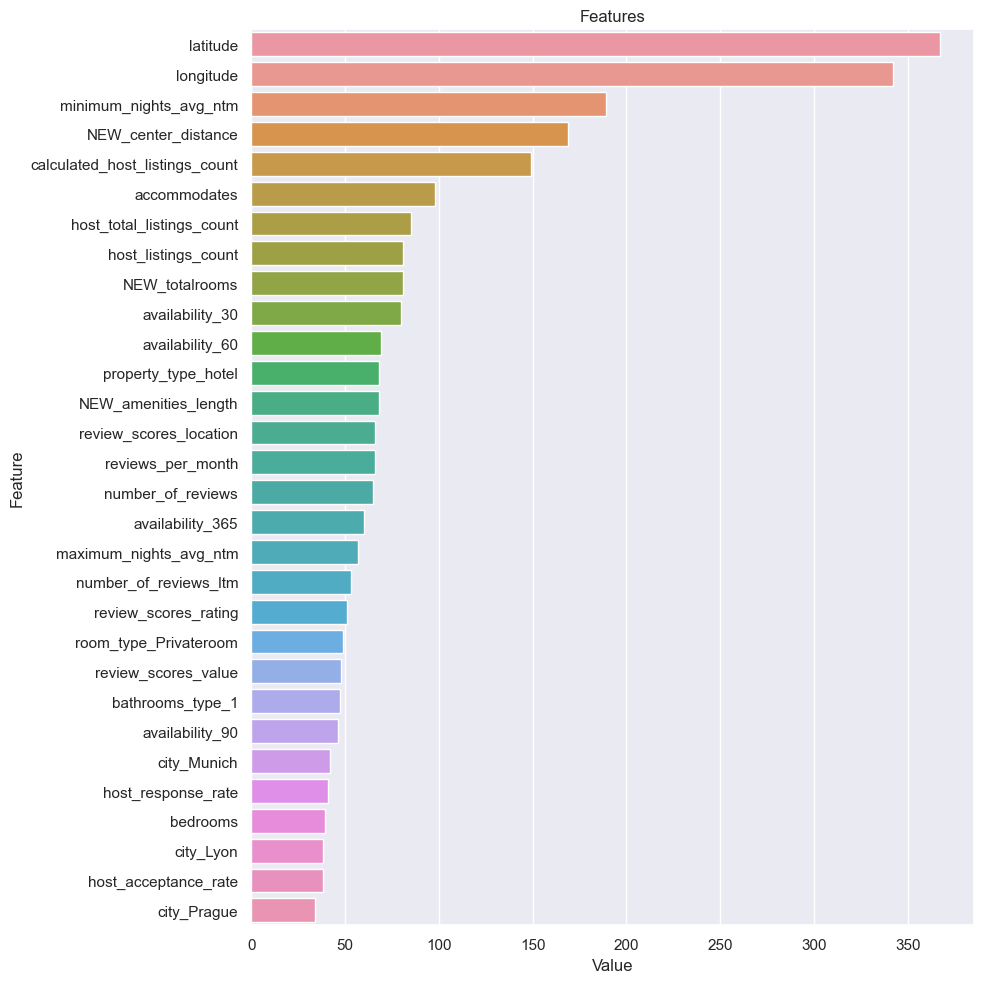

In [98]:
def plot_importance(model, features, num=30, save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(lgbm, X_train)

# Hyperparameter Optimization

In [99]:
import optuna

In [100]:
def objective(trial):
    param = {
      'boosting_type': 'dart',
      'metric': 'rmse',
      'learning_rate': 0.2,
      'random_state': 42,
      'num_leaves': trial.suggest_int('num_leaves', 100, 512),
      'n_estimators': trial.suggest_int('n_estimators', 500, 1000),
      'max_depth': trial.suggest_int('max_depth', 6, 10),
      'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
      'max_bin': trial.suggest_int('max_bin', 255, 500),
      }

    model = LGBMRegressor(**param)  
    
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    
    rmse = mean_squared_error(y_test, preds, squared=False)
    
    return rmse

In [101]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, n_jobs=-1)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-06-05 19:13:25,943] A new study created in memory with name: no-name-9ff0a0db-abb5-478b-b114-0b81ec50216b
[I 2023-06-05 19:15:34,390] Trial 5 finished with value: 37.52177266393445 and parameters: {'num_leaves': 252, 'n_estimators': 533, 'max_depth': 6, 'subsample': 1.0, 'max_bin': 429}. Best is trial 5 with value: 37.52177266393445.
[I 2023-06-05 19:16:07,561] Trial 2 finished with value: 36.85678885617194 and parameters: {'num_leaves': 439, 'n_estimators': 666, 'max_depth': 6, 'subsample': 0.7, 'max_bin': 483}. Best is trial 2 with value: 36.85678885617194.
[I 2023-06-05 19:16:49,568] Trial 0 finished with value: 36.580720562360256 and parameters: {'num_leaves': 362, 'n_estimators': 559, 'max_depth': 7, 'subsample': 0.6, 'max_bin': 449}. Best is trial 0 with value: 36.580720562360256.
[I 2023-06-05 19:17:09,718] Trial 3 finished with value: 36.83138442423789 and parameters: {'num_leaves': 253, 'n_estimators': 531, 'max_depth': 7, 'subsample': 0.4, 'max_bin': 487}. Best is tri

[I 2023-06-05 20:08:50,622] Trial 39 finished with value: 35.48772004031913 and parameters: {'num_leaves': 144, 'n_estimators': 794, 'max_depth': 10, 'subsample': 0.6, 'max_bin': 305}. Best is trial 32 with value: 35.36823484753425.
[I 2023-06-05 20:08:56,993] Trial 34 finished with value: 35.52524715230436 and parameters: {'num_leaves': 342, 'n_estimators': 951, 'max_depth': 10, 'subsample': 0.6, 'max_bin': 420}. Best is trial 32 with value: 35.36823484753425.
[I 2023-06-05 20:09:45,228] Trial 36 finished with value: 35.391894154440905 and parameters: {'num_leaves': 323, 'n_estimators': 943, 'max_depth': 10, 'subsample': 0.8, 'max_bin': 293}. Best is trial 32 with value: 35.36823484753425.
[I 2023-06-05 20:12:34,828] Trial 38 finished with value: 35.49918159559278 and parameters: {'num_leaves': 315, 'n_estimators': 786, 'max_depth': 10, 'subsample': 0.4, 'max_bin': 306}. Best is trial 32 with value: 35.36823484753425.
[I 2023-06-05 20:14:04,271] Trial 37 finished with value: 35.476031

Number of finished trials: 50
Best trial: {'num_leaves': 203, 'n_estimators': 834, 'max_depth': 10, 'subsample': 0.4, 'max_bin': 284}


In [111]:
best_params = {'metric': 'rmse', 'num_leaves': 203, 'n_estimators': 834, 'max_depth': 10, 'subsample': 0.4, 'max_bin': 284}
lgb_ = LGBMRegressor(**best_params).fit(X_train, y_train)

In [112]:
pred = lgb_.predict(X_test)

In [113]:
print(r2_score(y_test, pred))
print(mean_squared_error(y_test, pred,squared=False))

0.7023815000753122
35.716636556421506


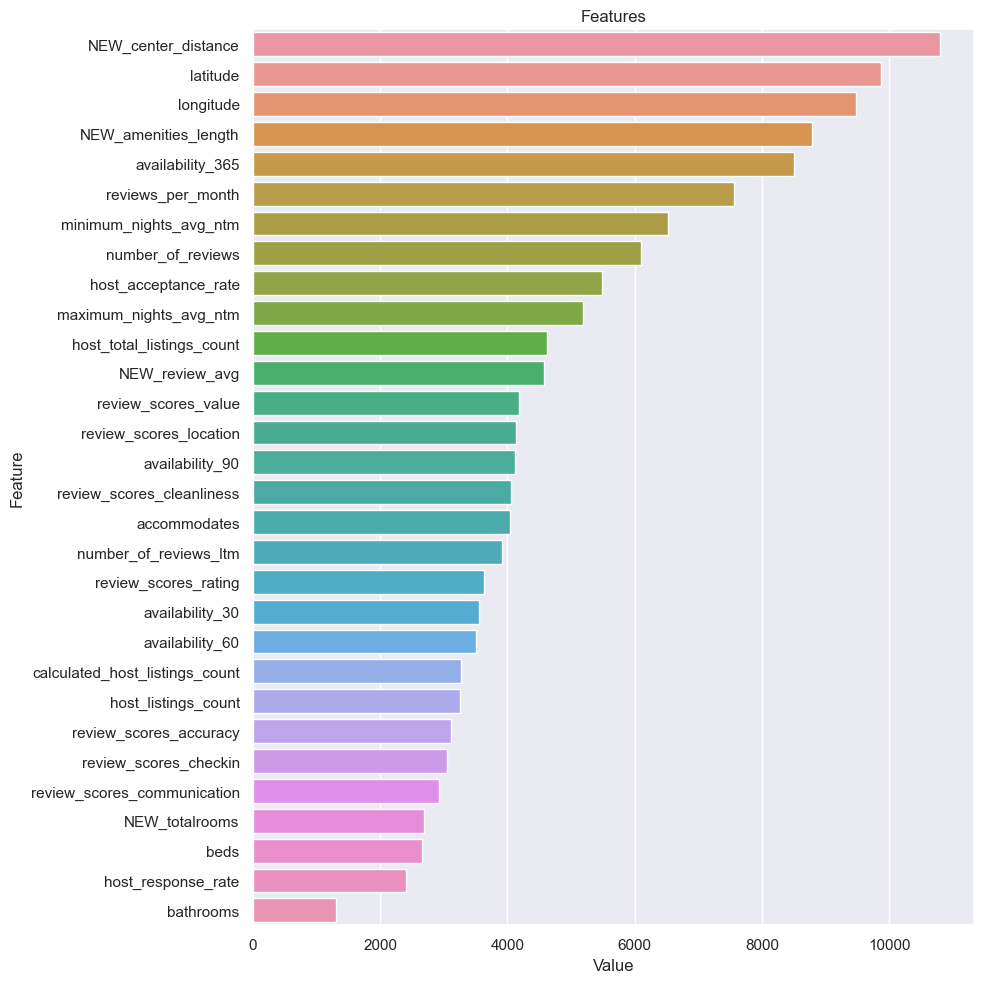

In [114]:
def plot_importance(model, features, num=30, save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(lgb_, X_train)

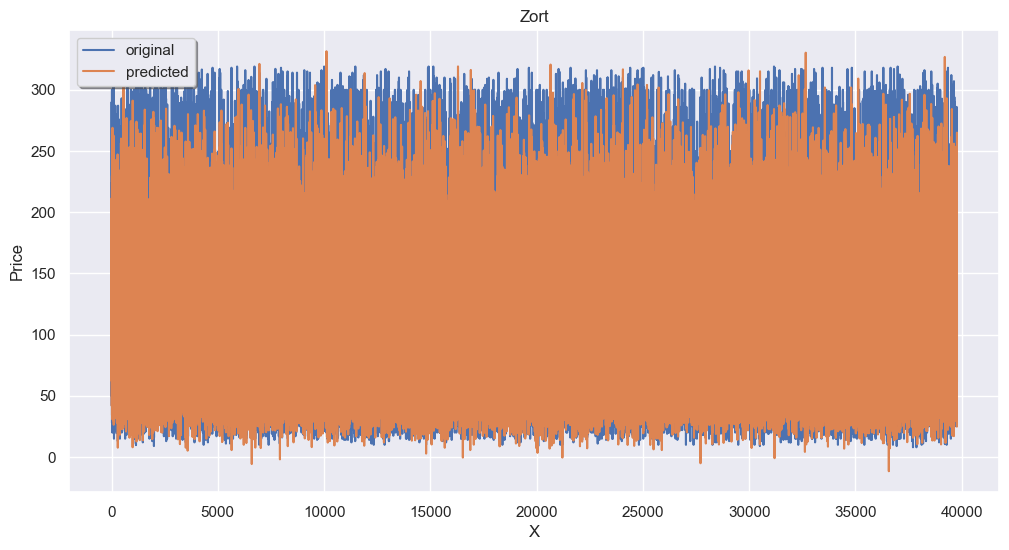

In [115]:
x_ax = range(len(y_test)) 
plt.figure(figsize=(12, 6)) 
plt.plot(x_ax, y_test, label="original") 
plt.plot(x_ax, pred, label="predicted") 
plt.title("Zort") 
plt.xlabel('X') 
plt.ylabel('Price') 
plt.legend(loc='best',fancybox=True, shadow=True) 
plt.grid(True) 
plt.show()

In [116]:
results_df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred }).reset_index(drop=True)
results_df["Error"] = results_df["Actual"] - results_df["Predicted"]
results_df["Percent_Error"] = abs(results_df["Error"]) * 100  / results_df["Actual"]

In [119]:
bins = [0, 50, 100, 150, 200, 250, 320]
category = ['0-50', '50-100', '100-150', "150-200", "200-250", "250-320"]
results_df['fiyat'] = pd.cut(results_df['Actual'], bins, labels = category)

In [120]:
results_df.groupby("fiyat").agg({"Predicted":["count","mean","min","max"],
                                 "Error":["mean","min","max"],
                                 "Percent_Error":["mean","min","max"]})

Predicted                          Error                  Percent_Error               
            count    mean    min     max    mean      min     max          mean   min      max
fiyat                                                                                         
0-50         7939  53.752  7.854 229.171 -17.391 -213.171  33.144        60.735 0.026 1587.747
50-100      15042  90.439 17.111 243.236 -14.057 -160.201  82.889        29.710 0.000  243.993
100-150      8434 126.728 28.631 263.697  -1.905 -144.697 110.321        20.174 0.001  121.594
150-200      4359 154.031 21.532 277.267  21.609 -107.267 178.468        18.654 0.003   89.234
200-250      2253 176.695 48.325 284.874  49.274  -59.006 196.794        22.888 0.003   78.718
250-320      1748 191.861 32.094 304.453  90.423  -26.190 261.527        31.808 0.460   89.069

In [ ]:
import pickle

In [ ]:
with open("model.pkl", 'wb') as f:
    pickle.dump(lgb_, f)